# Деревья решений 
В этом задании предстоит реализовать очень полезный метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений. Кроме того, этот метод часто используется в случаях, когда интерпретируемость модели имеет большое значение, например, в чувствительных задачах 

In [ ]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib

Основная идея любого алгоритма дерева решений заключается в следующем: 
1. Выберите лучший атрибут, используя меры выбора атрибута (ASM), чтобы разделить примеры. 
2.  Сделайте этот атрибут узлом решения и разбейте набор данных на более мелкие подмножества. 
3. Начните построение дерева, рекурсивно повторяя этот процесс для каждого дочернего элемента, пока не совпадет одно из условий:
   1. Все кортежи принадлежат одному и тому же значению атрибута. 
   2. Оставшихся атрибутов больше нет. 
   3. Больше нет примеров

## Использование различных моделей

Протестируем решение на датасетах [mushrooms](https://www.kaggle.com/datasets/uciml/mushroom-classification) и diabetes?.
1. Выполним загрузку и предобработку данных.
2. Разобьем данные на тренировочный и валидационный набор для оценки точности работы алгоритма.
3. Посчитаем метрики для различных параметров построения дерева

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
with open('../config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

Начнем с WDBC. В этом датасете хранятся геометрические и прочие внешние признаки опухолей (вероятно, полученные из МРТ). Опухоли будут быть доброкачественными (benign = B) и злокачественными (malignant = M). Задача состоит в определении типа опухоли по данным признакам

In [ ]:
df = pd.read_csv(cfg["classification"]["wdbc"])
df.head()

Как обычно, отбрасываем идентификатор

In [ ]:
df = df.drop(['id', 'Unnamed: 32'], axis=1)
df.head()

Трансформируем строковые категории B и M в числовые 0 и 1, после чего разделяем признаки и таргет, который будем предсказывать. Это дает нам датафреймы X и y соответственно.

In [ ]:
df['diagnosis'] = df['diagnosis'].replace({'B': 0, 'M': 1}).astype(int)
target = 'diagnosis'
features = list(df.columns)
features.remove('diagnosis')
features

In [ ]:
X_diagnosis = df[features]
y_diagnosis = df[[target]]

Рассмотрим теперь датасет mushrooms. В нем содержатся геометрические и прочие внешние признаки грибов, которые классифицируются на съедобные и ядовитые. Наша задача состоит в подобной классификации по данным признакам

In [34]:
df = pd.read_csv(cfg["classification"]["mushrooms"])
target = 'class'
features = list(df.columns)
features.remove(target)
X_mushroom = df[features]
y_mushroom = df[[target]]
X_mushroom.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


**Задание**: Проведите краткий EDA. Есть ли выбросы в данных, как связаны столбцы? Хватит 2-3 графиков или таблиц (но можно больше). Какие есть типы признаков в этом датасете?

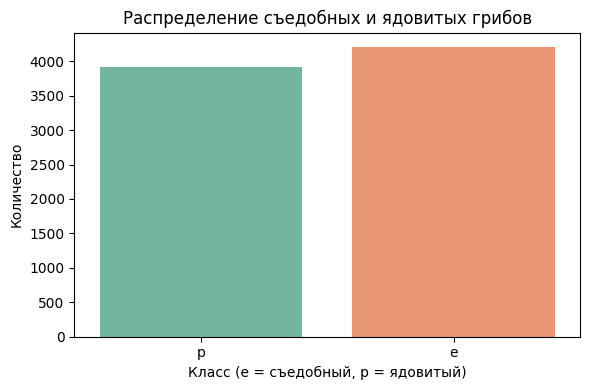

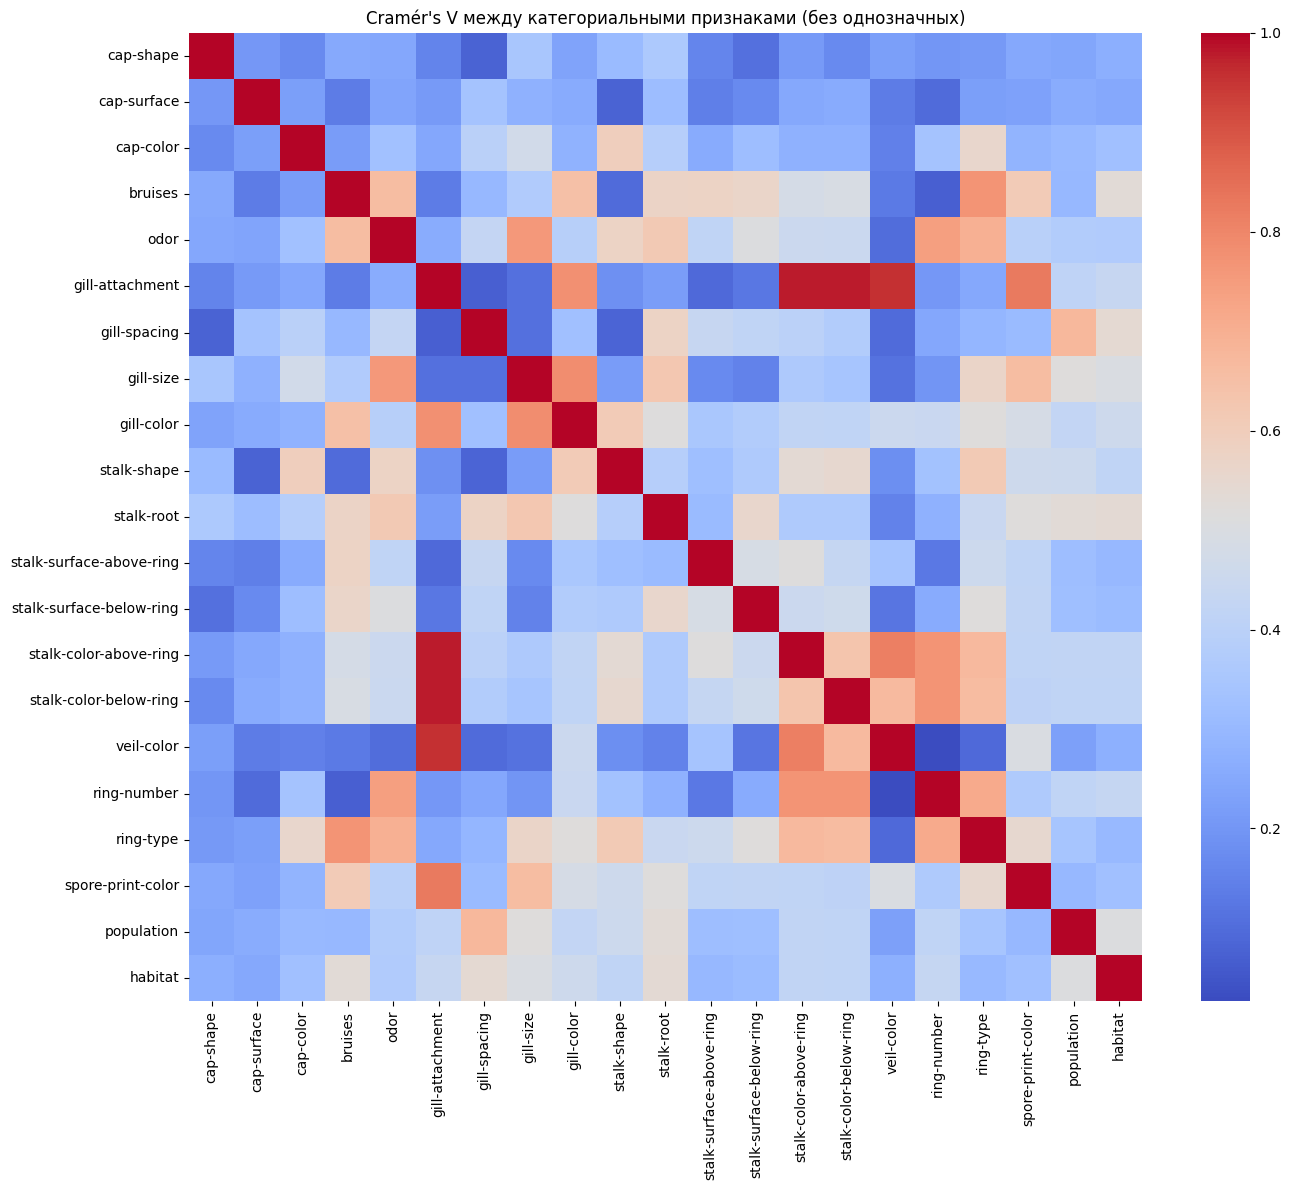

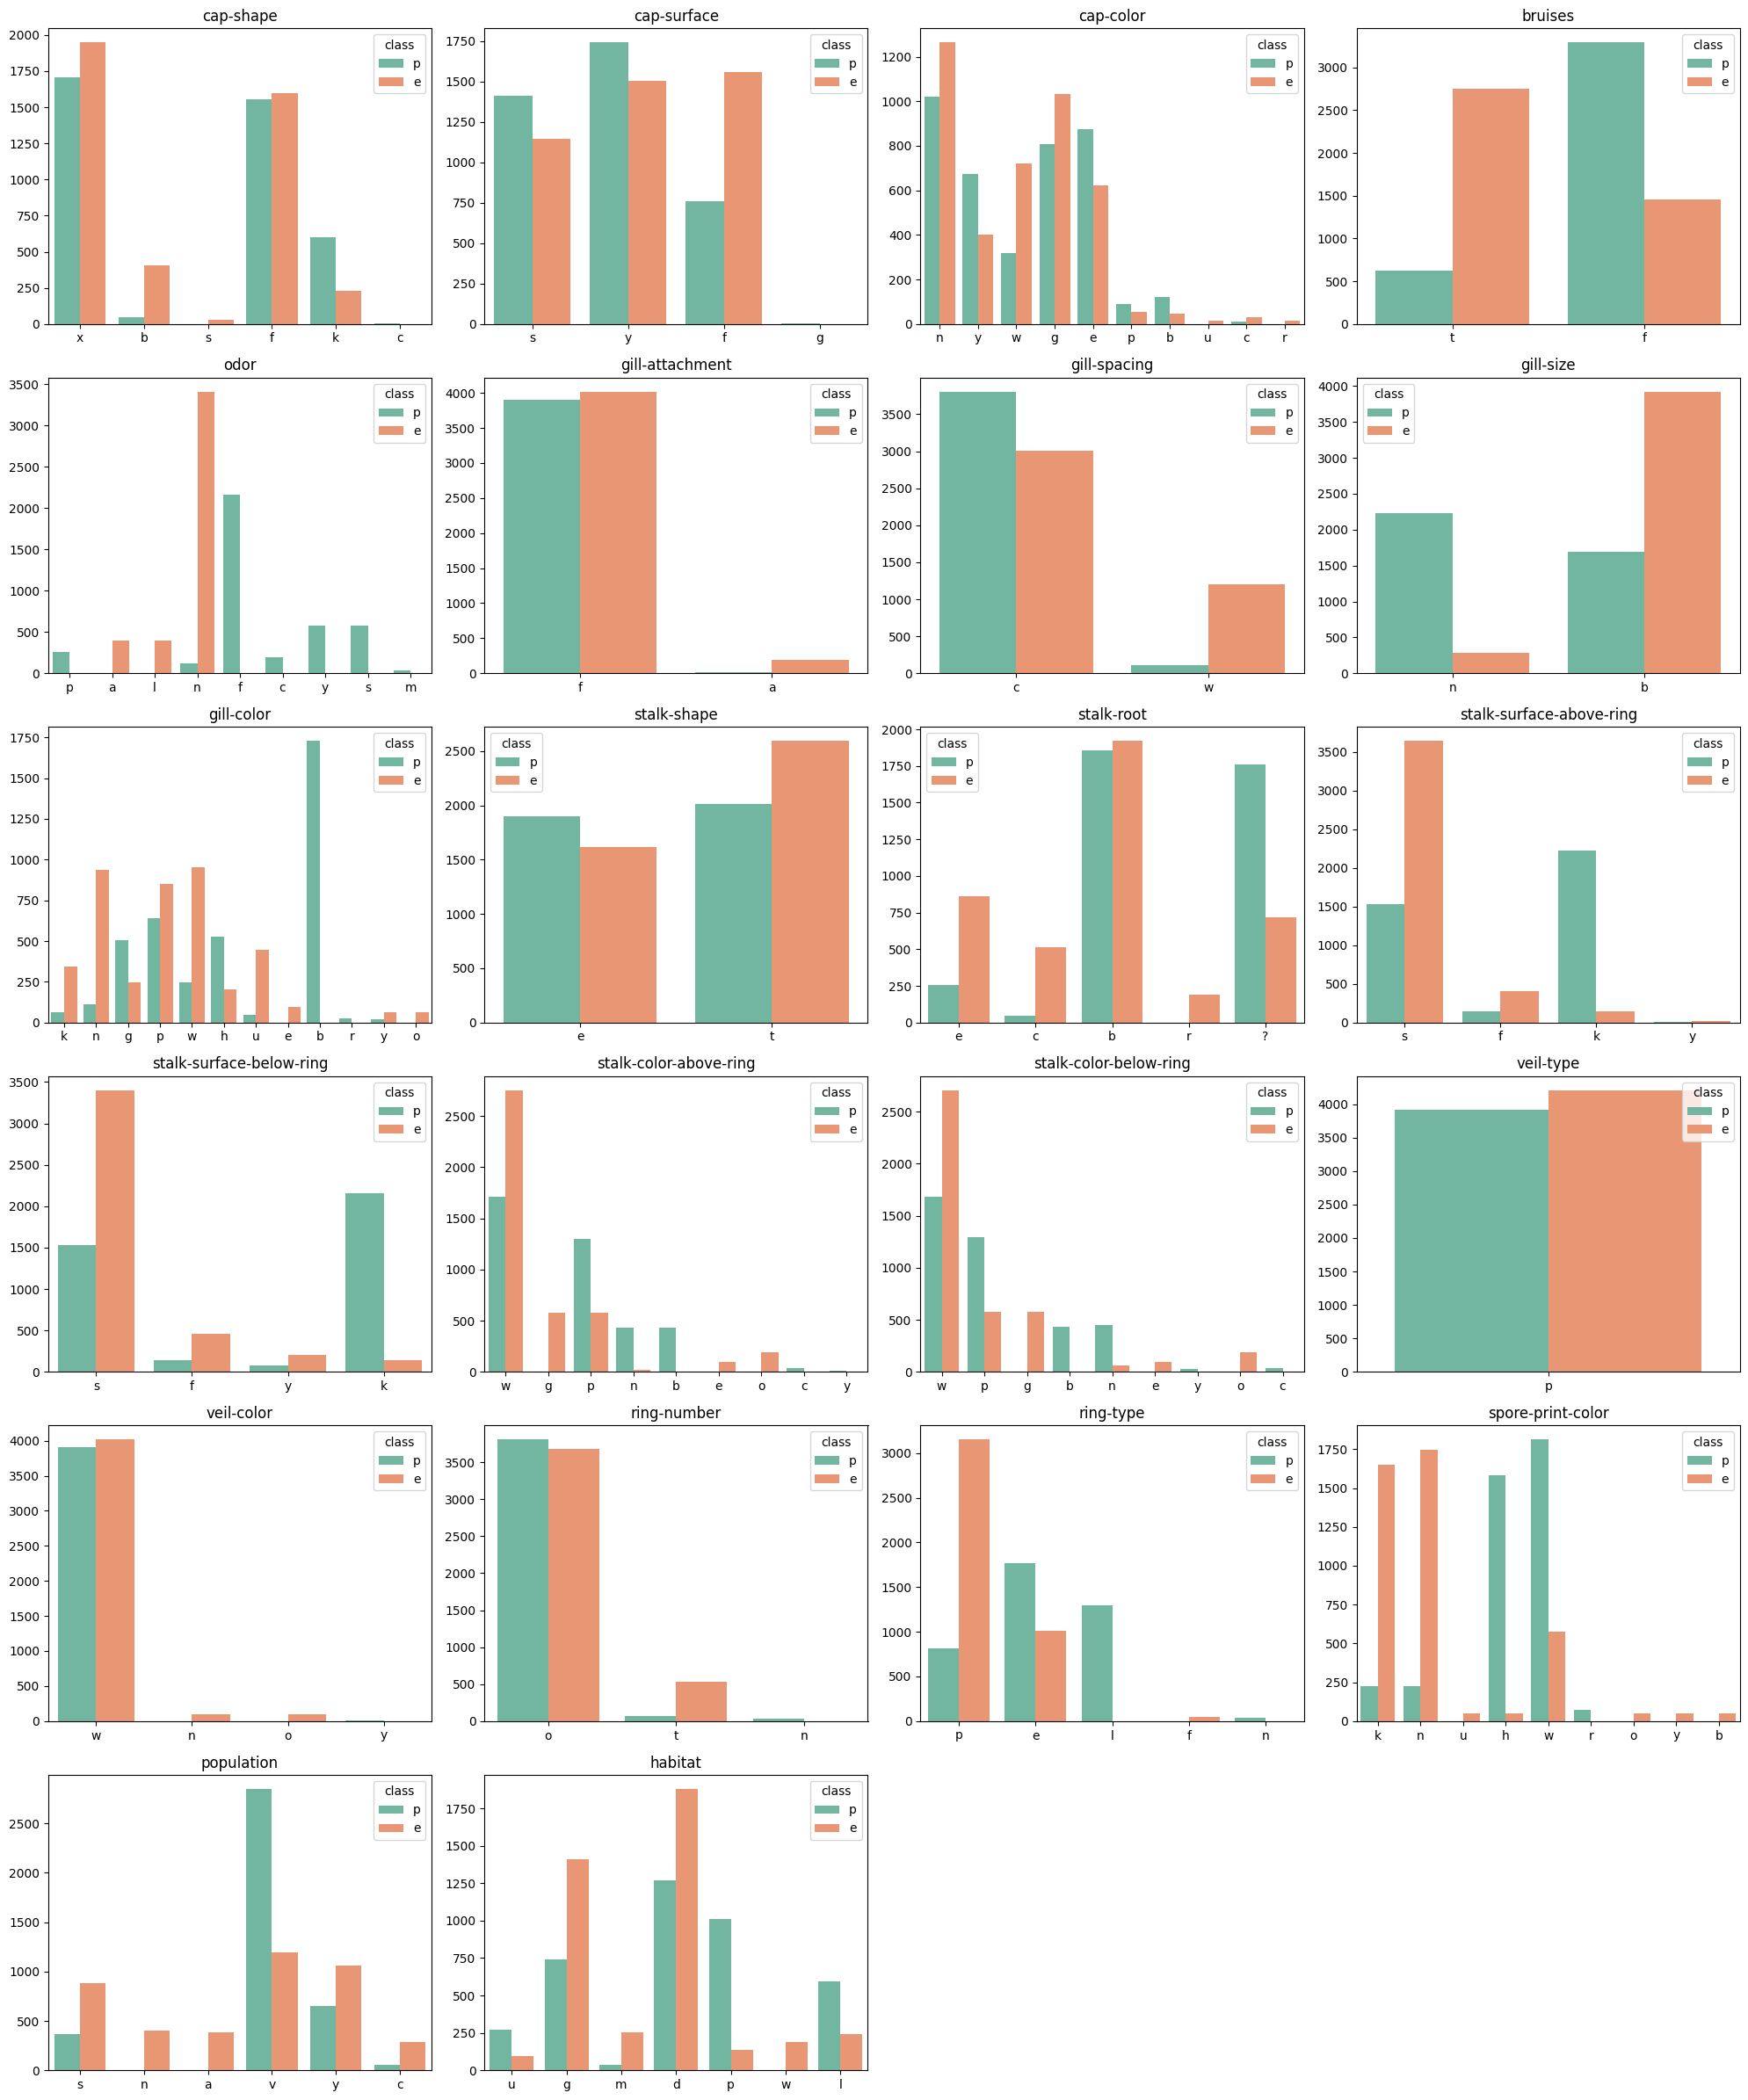

In [35]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Распределение классов
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="class", hue="class", palette="Set2", legend=False)
plt.title("Распределение съедобных и ядовитых грибов")
plt.xlabel("Класс (e = съедобный, p = ядовитый)")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

# Тепловая карта
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] == 1 or confusion_matrix.shape[1] == 1:
        return np.nan  # нельзя вычислить Cramér's V
    try:
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
        rcorr = r - ((r - 1)**2) / (n - 1)
        kcorr = k - ((k - 1)**2) / (n - 1)
        denom = min((kcorr - 1), (rcorr - 1))
        if denom == 0:
            return np.nan
        return np.sqrt(phi2corr / denom)
    except:
        return np.nan

unique_counts = df.nunique()
df_filtered = df.loc[:, unique_counts > 1]
cols = df_filtered.columns

df_filtered = df.drop(columns=["class"])
df_filtered = df_filtered.loc[:, df_filtered.nunique() > 1]
cols = df_filtered.columns

cramer_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)
for col1 in cols:
    for col2 in cols:
        cramer_matrix.loc[col1, col2] = cramers_v(df_filtered[col1], df_filtered[col2])

plt.figure(figsize=(14, 12))
sns.heatmap(cramer_matrix, cmap="coolwarm", annot=False)
plt.title("Cramér's V между категориальными признаками (без однозначных)")
plt.tight_layout()
plt.show()

# Матрица графиков для всех признаков
df_plot = df
cat_features = [col for col in df_plot.columns if col != "class"]

n_cols = 4
n_rows = math.ceil(len(cat_features) / n_cols)
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(cat_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(data=df_plot, x=col, hue="class", palette="Set2")
    plt.title(f"{col}")
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()

In [36]:
import category_encoders as ce

encoder = ce.CountEncoder()
X_mushroom = encoder.fit_transform(X_mushroom)
X_mushroom.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,3656,2556,2284,3376,256,7914,6812,2512,408,3516,...,4936,4464,4384,8124,7924,7488,3968,1872,1248,368
1,3656,2556,1072,3376,400,7914,6812,5612,408,3516,...,4936,4464,4384,8124,7924,7488,3968,1968,400,2148
2,452,2556,1040,3376,400,7914,6812,5612,1048,3516,...,4936,4464,4384,8124,7924,7488,3968,1968,400,292
3,3656,3244,1040,3376,256,7914,6812,2512,1048,3516,...,4936,4464,4384,8124,7924,7488,3968,1872,1248,368
4,3656,2556,1840,4748,3528,7914,1312,5612,408,4608,...,4936,4464,4384,8124,7924,7488,2776,1968,384,2148


In [37]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_mushroom = encoder.fit_transform(y_mushroom)

c:\Users\Slava Bek\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Теперь перейдем к предсказанию типа опухолей с помощью деревьев решений.

Проведем train/test сплит

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_diagnosis, y_diagnosis, test_size=0.2, random_state=1)

In [39]:
y_train

,diagnosis
408,1
4,1
307,0
386,0
404,0
...,...
129,1
144,0
72,1
235,0


Поэкспериментируем с деревом решений из библиотеки sklearn. 

In [40]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)

In [41]:
tree.predict_proba(X_test)[:, 1]

array([0.83333333, 0.26666667, 0.        , 0.4375    , 0.4375    ,
       1.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.83333333, 1.        , 0.        , 0.4375    ,
       0.03333333, 0.        , 0.        , 0.26666667, 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.83333333,
       0.26666667, 0.        , 1.        , 1.        , 0.4375    ,
       1.        , 0.        , 1.        , 0.83333333, 0.        ,
       0.        , 0.4375    , 0.03333333, 0.26666667, 0.        ,
       0.        , 0.26666667, 0.03333333, 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 0.03333333,
       0.        , 0.        , 0.4375    , 0.        , 0.        ,
       0.        , 0.26666667, 0.83333333, 0.03333333, 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.03333

In [42]:
tree.score(X_test, y_test)
#metrics.roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])

0.8421052631578947

[Text(0.5, 0.875, 'x[22] <= 106.05\ngini = 0.468\nsamples = 455\nvalue = [285, 170]'),
 Text(0.3, 0.625, 'x[27] <= 0.117\ngini = 0.064\nsamples = 271\nvalue = [262, 9]'),
 Text(0.4, 0.75, 'True  '),
 Text(0.2, 0.375, 'x[13] <= 28.915\ngini = 0.008\nsamples = 241\nvalue = [240, 1]'),
 Text(0.1, 0.125, 'gini = 0.0\nsamples = 211\nvalue = [211, 0]'),
 Text(0.3, 0.125, 'gini = 0.064\nsamples = 30\nvalue = [29, 1]'),
 Text(0.4, 0.375, 'gini = 0.391\nsamples = 30\nvalue = [22, 8]'),
 Text(0.7, 0.625, 'x[6] <= 0.086\ngini = 0.219\nsamples = 184\nvalue = [23, 161]'),
 Text(0.6, 0.75, '  False'),
 Text(0.6, 0.375, 'gini = 0.492\nsamples = 32\nvalue = [18, 14]'),
 Text(0.8, 0.375, 'x[20] <= 17.675\ngini = 0.064\nsamples = 152\nvalue = [5, 147]'),
 Text(0.7, 0.125, 'gini = 0.278\nsamples = 30\nvalue = [5, 25]'),
 Text(0.9, 0.125, 'gini = 0.0\nsamples = 122\nvalue = [0, 122]')]

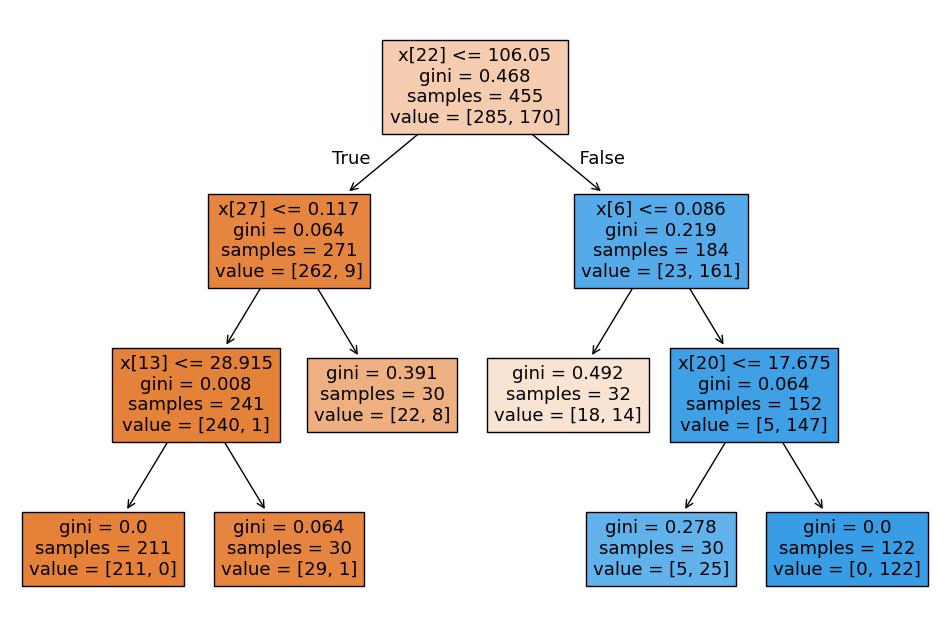

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree, ax=ax, filled=True)

Рассмотрим другие значения гиперпараметров

[Text(0.5, 0.875, 'x[22] <= 106.05\ngini = 0.468\nsamples = 455\nvalue = [285, 170]'),
 Text(0.25, 0.625, 'x[27] <= 0.159\ngini = 0.064\nsamples = 271\nvalue = [262, 9]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[27] <= 0.135\ngini = 0.03\nsamples = 265\nvalue = [261, 4]'),
 Text(0.0625, 0.125, 'gini = 0.008\nsamples = 254\nvalue = [253, 1]'),
 Text(0.1875, 0.125, 'gini = 0.397\nsamples = 11\nvalue = [8, 3]'),
 Text(0.375, 0.375, 'x[1] <= 16.22\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.75, 0.625, 'x[21] <= 20.645\ngini = 0.219\nsamples = 184\nvalue = [23, 161]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[22] <= 116.8\ngini = 0.388\nsamples = 19\nvalue = [14, 5]'),
 Text(0.5625, 0.125, 'gini = 0.0\nsamples = 13\nvalue = [13, 0]'),
 Text(0.6875, 0.125, 'gini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.875, 0.375, 'x[7] <

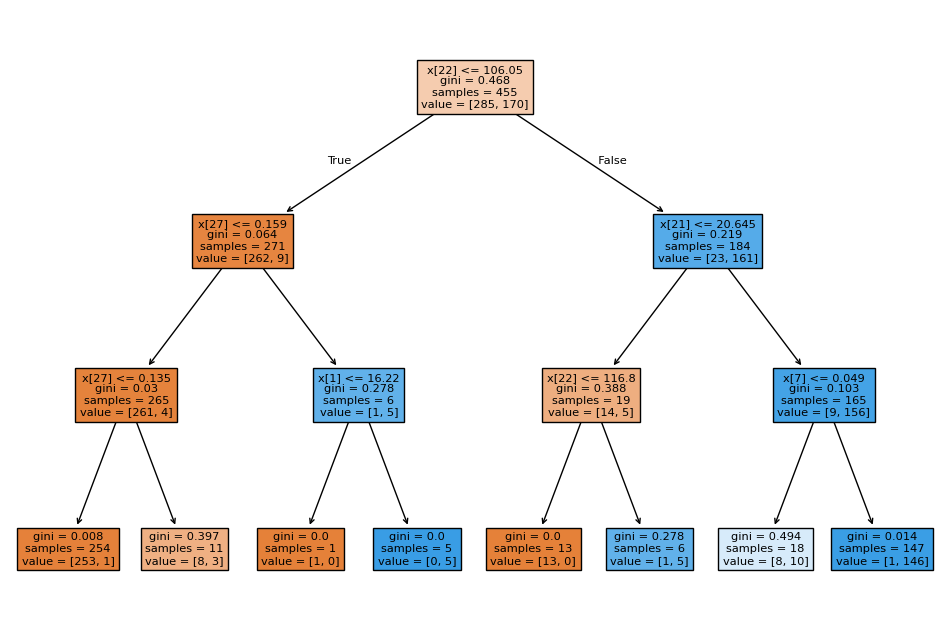

In [44]:
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree_gini.fit(X_train, y_train), ax=ax, filled=True)

In [45]:
print('Training-set accuracy score: {0:0.4f}'. format(tree_gini.score(X_train, y_train)))
print('Test-set accuracy score: {0:0.4f}'. format(tree_gini.score(X_test, y_test)))

Training-set accuracy score: 0.9692
Test-set accuracy score: 0.9123


Попробуем вместо Джини использовать энтропию

[Text(0.5, 0.875, 'perimeter_worst <= 105.15\nentropy = 0.953\nsamples = 455\nvalue = [285, 170]\nclass = 0'),
 Text(0.25, 0.625, 'concave points_worst <= 0.135\nentropy = 0.176\nsamples = 266\nvalue = [259, 7]\nclass = 0'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'radius_se <= 0.643\nentropy = 0.037\nsamples = 252\nvalue = [251, 1]\nclass = 0'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 249\nvalue = [249, 0]\nclass = 0'),
 Text(0.1875, 0.125, 'entropy = 0.918\nsamples = 3\nvalue = [2, 1]\nclass = 0'),
 Text(0.375, 0.375, 'texture_worst <= 25.94\nentropy = 0.985\nsamples = 14\nvalue = [8, 6]\nclass = 0'),
 Text(0.3125, 0.125, 'entropy = 0.0\nsamples = 6\nvalue = [6, 0]\nclass = 0'),
 Text(0.4375, 0.125, 'entropy = 0.811\nsamples = 8\nvalue = [2, 6]\nclass = 1'),
 Text(0.75, 0.625, 'concave points_worst <= 0.151\nentropy = 0.578\nsamples = 189\nvalue = [26, 163]\nclass = 1'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'texture_worst <= 19.91\nentropy = 0.998\nsamp

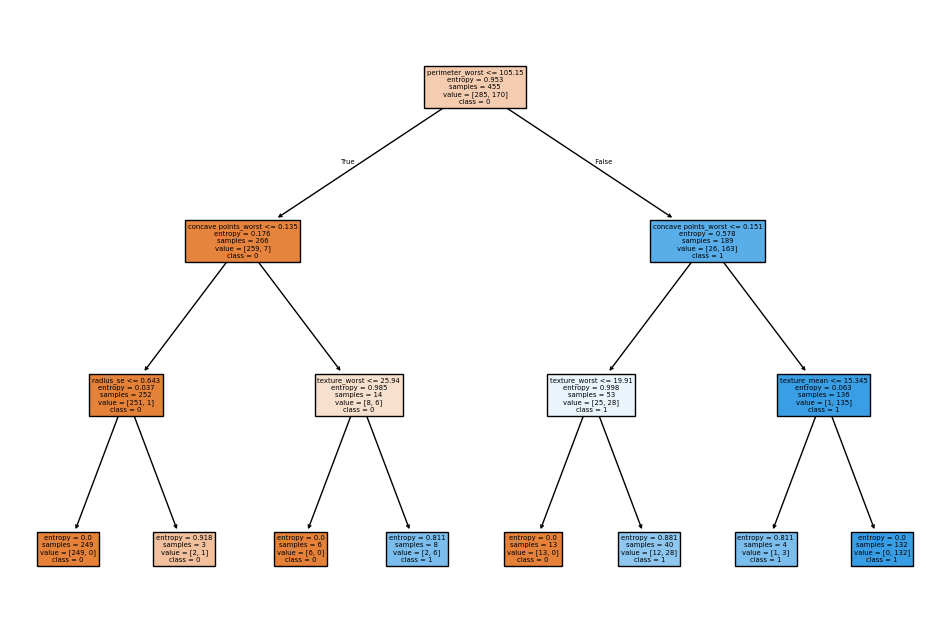

In [46]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

tree_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree_en.fit(X_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree_en, ax=ax, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in tree_en.classes_])

In [47]:
print('Training set score: {:.4f}'.format(tree_en.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(tree_en.score(X_test, y_test)))

Training set score: 0.9648
Test set score: 0.9123


Перейдем теперь к датасету с грибами

[Text(0.4666666666666667, 0.9166666666666666, 'x[4] <= 2844.0\ngini = 0.499\nsamples = 6499\nvalue = [3388.0, 3111.0]'),
 Text(0.26666666666666666, 0.75, 'x[10] <= 838.0\ngini = 0.288\nsamples = 3660\nvalue = [637, 3023]'),
 Text(0.3666666666666667, 0.8333333333333333, 'True  '),
 Text(0.13333333333333333, 0.5833333333333334, 'x[20] <= 370.0\ngini = 0.098\nsamples = 580\nvalue = [550, 30]'),
 Text(0.06666666666666667, 0.4166666666666667, 'gini = 0.0\nsamples = 30\nvalue = [0, 30]'),
 Text(0.2, 0.4166666666666667, 'gini = 0.0\nsamples = 550\nvalue = [550, 0]'),
 Text(0.4, 0.5833333333333334, 'x[6] <= 4062.0\ngini = 0.055\nsamples = 3080\nvalue = [87, 2993]'),
 Text(0.3333333333333333, 0.4166666666666667, 'x[3] <= 4062.0\ngini = 0.495\nsamples = 158\nvalue = [87.0, 71.0]'),
 Text(0.26666666666666666, 0.25, 'gini = 0.0\nsamples = 87\nvalue = [87, 0]'),
 Text(0.4, 0.25, 'gini = 0.0\nsamples = 71\nvalue = [0, 71]'),
 Text(0.4666666666666667, 0.4166666666666667, 'gini = 0.0\nsamples = 2922\n

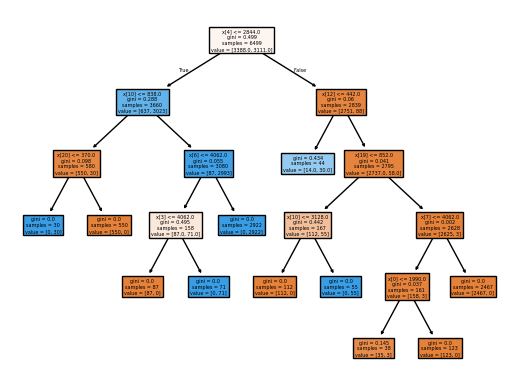

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_mushroom, y_mushroom, test_size=0.2, random_state=1)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
plot_tree(tree.fit(X_train, y_train), filled=True)

In [49]:
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)
print('Training-set accuracy score: {0:0.4f}'. format(tree.score(X_train, y_train)))
print('Test-set accuracy score: {0:0.4f}'. format(tree.score(X_test, y_test)))

Training-set accuracy score: 0.9974
Test-set accuracy score: 0.9957


Сравним, как разные классификаторы строят границы разделения. Для начала посмотрим на общую картинку, как в зависимости от настроек будет отличаться дерево.

In [50]:
classifiers = {
    "DT_basic_3": DecisionTreeClassifier(max_depth=3),
    "DT_basic_5_no_min": DecisionTreeClassifier(max_depth=5),
    "DT_basic_5": DecisionTreeClassifier(max_depth=5, min_samples_leaf=30),
    "DT_gini_3": DecisionTreeClassifier(max_depth=3, criterion='gini',  min_samples_leaf=30),
    "DT_gini_5": DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_leaf=30),
    "DT_entropy_3": DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_leaf=30),
    "DT_entropy_5": DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_leaf=30),
    "DT_entropy_5_no_min": DecisionTreeClassifier(max_depth=5, criterion='entropy'),
}
    

columns =  X_diagnosis.columns[:2] 
columns_mushroom = ['gill-color', 'cap-color']

datasets = [
    (X_diagnosis[columns].to_numpy(), y_diagnosis.to_numpy()),
    (X_mushroom[columns_mushroom].to_numpy(), y_mushroom),
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1)
]


In [51]:
def set_grid(ax, i, j, x_min, x_max, y_min, y_max):
    ax[i][j].set_xlim(x_min, x_max)
    ax[i][j].set_ylim(y_min, y_max)
    ax[i][j].set_xticks(())
    ax[i][j].set_yticks(())

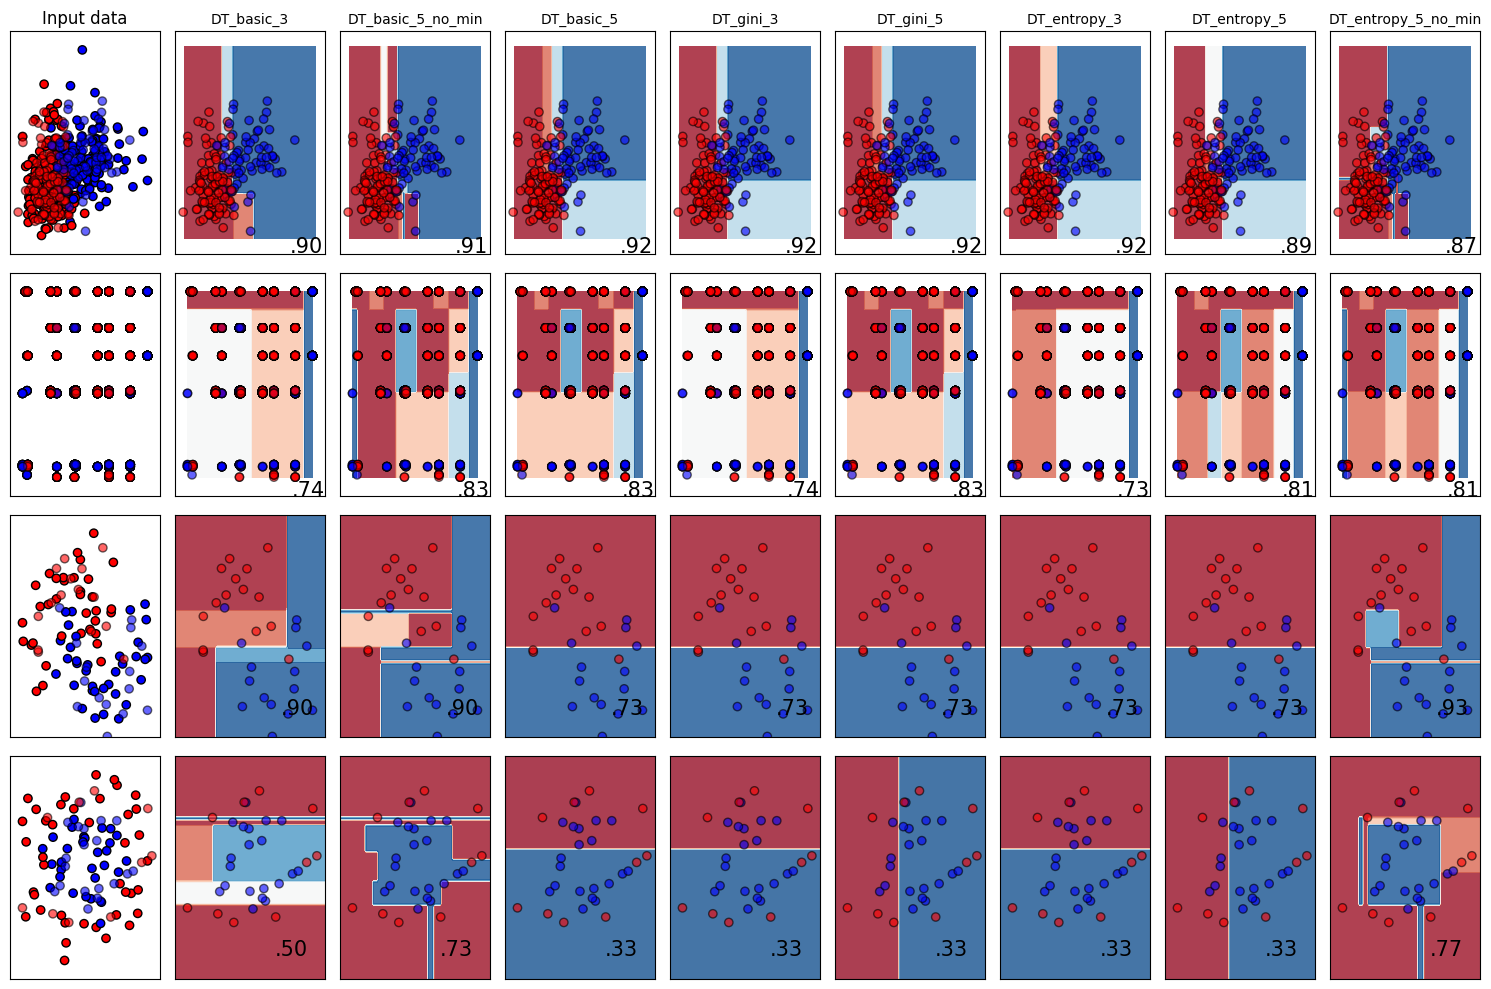

In [52]:
fig, ax = plt.subplots(len(datasets), len(classifiers)+1, figsize=(15, 10))

for dataset_num, data in enumerate(datasets):
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42
      )
    diff_x = X_train[:, 0].max() - X_train[:, 0].min()
    diff_y = X_train[:, 1].max() - X_train[:, 1].min()
    x_min, x_max = X_train[:, 0].min() - diff_x*0.1, X_train[:, 0].max() + diff_x*0.1
    y_min, y_max = X_train[:, 1].min() - diff_y*0.1, X_train[:, 1].max() + diff_y*0.1


    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    if dataset_num == 0:
          ax[dataset_num][0].set_title("Input data")
            
    # Plot the training points
    ax[dataset_num][0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax[dataset_num][0].scatter(
      X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    set_grid(ax, dataset_num, 0, x_min, x_max, y_min, y_max)
    
    # iterate over classifiers
    for cls_num, (name, clf) in enumerate(classifiers.items(), start=1):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X_train, cmap=cm, alpha=0.8, ax=ax[dataset_num][cls_num], eps=0.5
        )
        
        # Plot the training points
        #ax[dataset_num][cls_num].scatter(
        #    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        #)
        
        # Plot the testing points
        ax[dataset_num][cls_num].scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        set_grid(ax, dataset_num, cls_num, x_min, x_max, y_min, y_max)
        if dataset_num == 0:
            ax[dataset_num][cls_num].set_title(name, fontdict={'fontsize': 10, 'fontweight': 'medium'})
            
        ax[dataset_num][cls_num].text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )

plt.tight_layout()
plt.show()

Деревья решений легко переобучаются. В теории, каждая точка набора может сформировать листовую вершину. Поэтому всегда надо аккуратно выбирать гиперпараметры, влияющие на разбиение дерева. Кроме того, деревья чувствительны к обучающе выборке. Даже небольшая ее пертурбация может привести к очень серьезным изменениям в классификаторе.

**Задание**: 
1) Постройте несколько графиков, чтобы оценить, как будет выглядить разделение плоскости в зависимости от 
    - минимального количества объектов в листе
    - максимальной глубины дерева
  К увеличению или уменьшению качества на обучающей выборке приводит увеличение глубины дерева? А на тестовой? 
2) Постройте несколько графиков, чтобы оценить, как будет выглядить разделение плоскости в зависимости от подвыборки. Выберите из вашего обучающего набора 90% семплов с разными сидами и посмотрите, как поменяются предсказания.

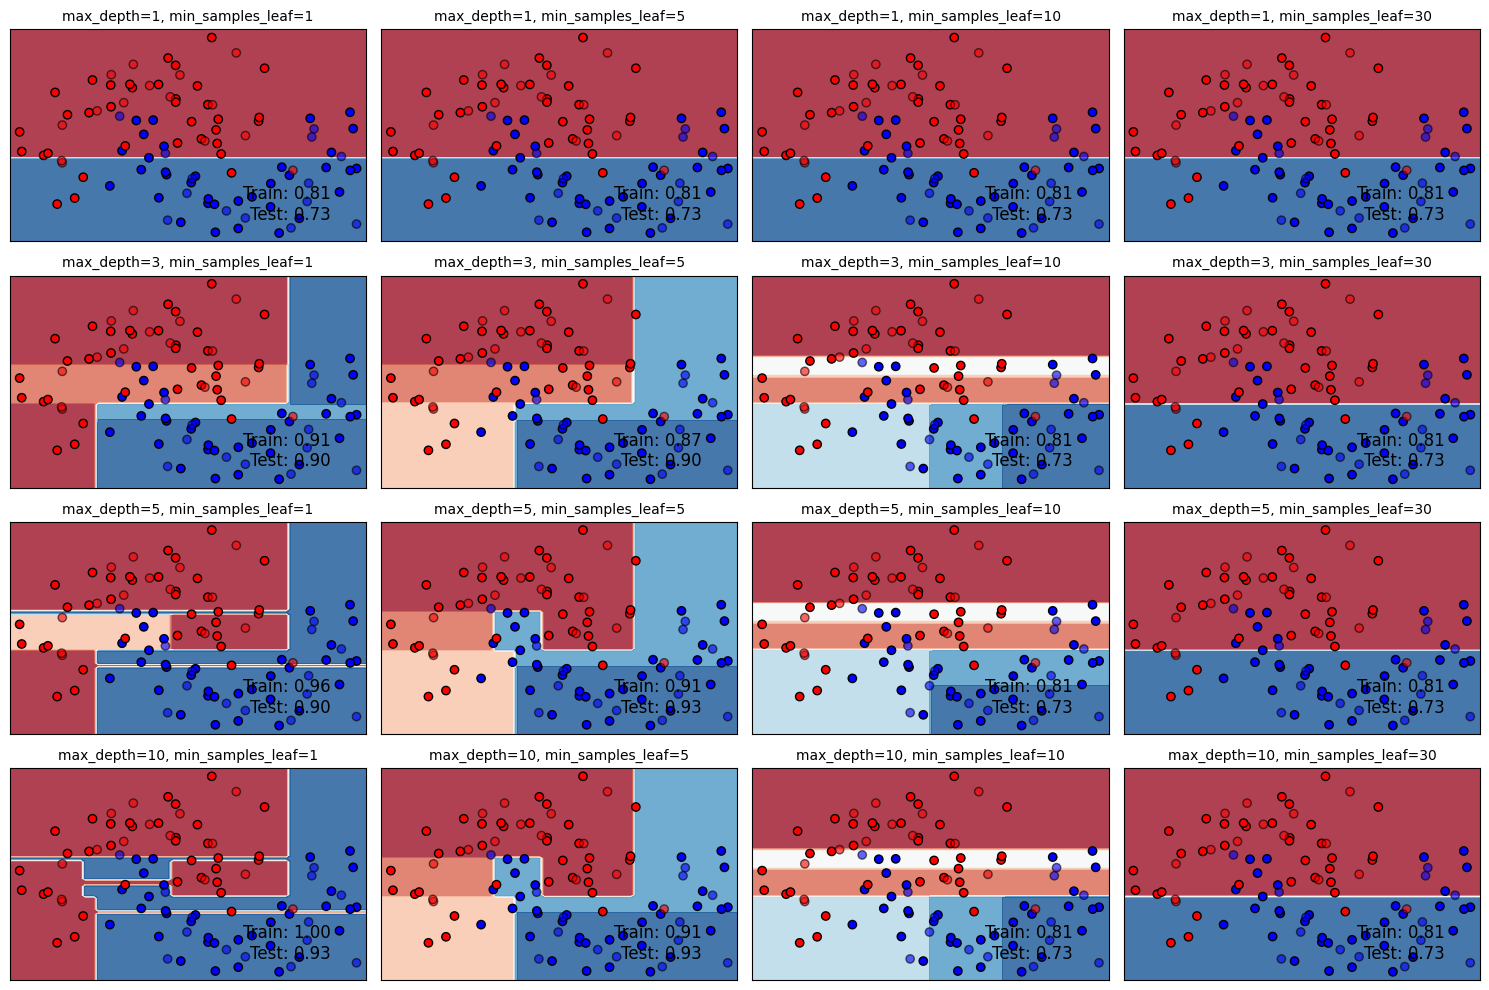

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

X, y = make_moons(noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

max_depths = [1, 3, 5, 10]
min_samples_leafs = [1, 5, 10, 30]

fig, ax = plt.subplots(len(max_depths), len(min_samples_leafs), figsize=(15, 10))

for i, max_depth in enumerate(max_depths):
    for j, min_samples_leaf in enumerate(min_samples_leafs):
        
        # Обучаем модель
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(X_train, y_train)

        # Оценка точности
        train_score = accuracy_score(y_train, clf.predict(X_train))
        test_score = accuracy_score(y_test, clf.predict(X_test))

        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        DecisionBoundaryDisplay.from_estimator(clf, X_train, cmap=cm, alpha=0.8, ax=ax[i][j], eps=0.5)

        ax[i][j].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", label="Train")
        ax[i][j].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k", label="Test")

        ax[i][j].set_xlim(X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1)
        ax[i][j].set_ylim(X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1)
        ax[i][j].set_xticks(())
        ax[i][j].set_yticks(())

        ax[i][j].set_title(f"max_depth={max_depth}, min_samples_leaf={min_samples_leaf}", fontsize=10)
        ax[i][j].text(
            0.9, 0.1,
            f"Train: {train_score:.2f}\nTest: {test_score:.2f}",
            size=12,
            horizontalalignment="right",
            transform=ax[i][j].transAxes
        )

plt.tight_layout()
plt.show()

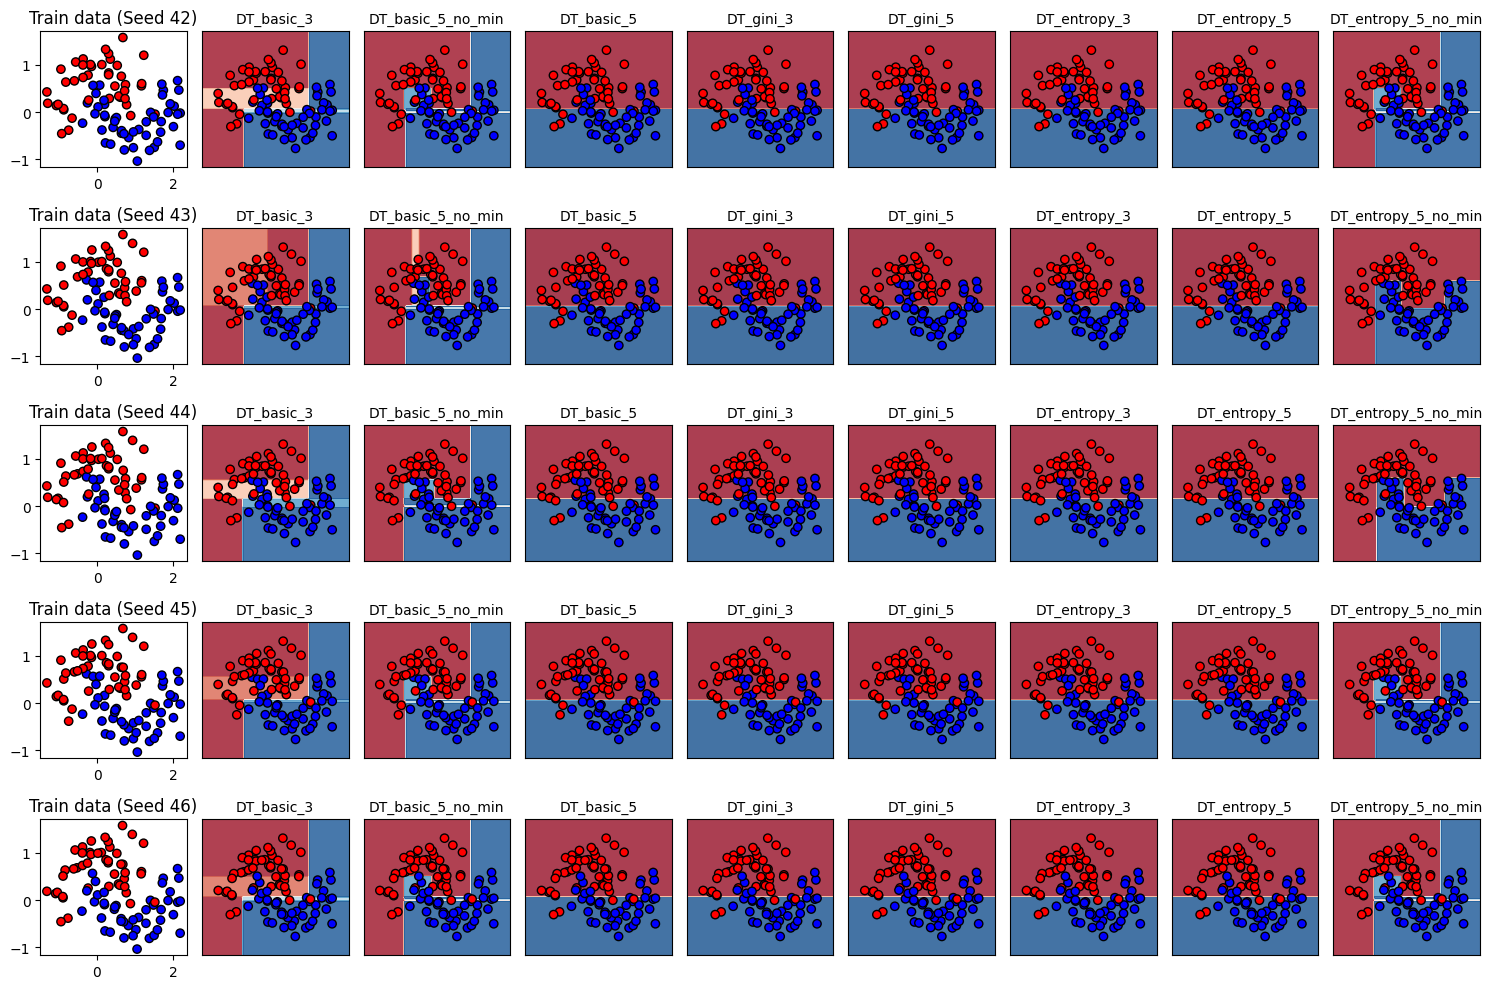

In [54]:
n_sids = 5

classifiers = {
    "DT_basic_3": DecisionTreeClassifier(max_depth=3),
    "DT_basic_5_no_min": DecisionTreeClassifier(max_depth=5),
    "DT_basic_5": DecisionTreeClassifier(max_depth=5, min_samples_leaf=30),
    "DT_gini_3": DecisionTreeClassifier(max_depth=3, criterion='gini',  min_samples_leaf=30),
    "DT_gini_5": DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_leaf=30),
    "DT_entropy_3": DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_leaf=30),
    "DT_entropy_5": DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_leaf=30),
    "DT_entropy_5_no_min": DecisionTreeClassifier(max_depth=5, criterion='entropy'),
}

fig, ax = plt.subplots(n_sids, len(classifiers)+1, figsize=(15, 10))

for i, seed in enumerate(range(42, 42 + n_sids)):
    X_train_sub, _, y_train_sub, _ = train_test_split(X, y, train_size=0.9, random_state=seed) # Подвыборка 90% данных

    # Просто данные
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax[i][0].set_title(f"Train data (Seed {seed})")
    ax[i][0].scatter(X_train_sub[:, 0], X_train_sub[:, 1], c=y_train_sub, cmap=cm_bright, edgecolors="k")

    # Перебор классификаторов
    for cls_num, (name, clf) in enumerate(classifiers.items(), start=1):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train_sub, y_train_sub)

        DecisionBoundaryDisplay.from_estimator(clf, X_train_sub, cmap=plt.cm.RdBu, alpha=0.8, ax=ax[i][cls_num], eps=0.5) # Разделяющая плоскость

        ax[i][cls_num].scatter(X_train_sub[:, 0], X_train_sub[:, 1], c=y_train_sub, cmap=cm_bright, edgecolors="k", label="Train")
        ax[i][cls_num].set_xticks(())
        ax[i][cls_num].set_yticks(())
        ax[i][cls_num].set_title(name, fontsize=10)

plt.tight_layout()
plt.show()

**Задание:**
  Для датасета mushrooms сравните, как меняется точность и переобучение для деревьев с разными кодировками признаков. Можете зафиксировать остальные параметры. 

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder

# Функция для оценки модели: обучение и вывод метрик
def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    clf = DecisionTreeClassifier(random_state=42, max_depth=5)
    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    overfit = train_acc - test_acc
    return train_acc, test_acc, overfit

y = df['class']
X = df.drop(columns=['class'])

# Ordinal Encoding
encoder = OrdinalEncoder()
X_ord = pd.DataFrame(encoder.fit_transform(X), columns=X.columns)
train_acc, test_acc, overfit = evaluate_model(X_ord, y)
print("Ordinal Encoding:")
print("Train Accuracy: {:.3f}".format(train_acc))
print("Test Accuracy:  {:.3f}".format(test_acc))
print("Overfitting:   {:.3f}".format(overfit))

# One-Hot Encoding
X_onehot = pd.get_dummies(X, drop_first=True)
train_acc, test_acc, overfit = evaluate_model(X_onehot, y)
print("\nOne-Hot Encoding:")
print("Train Accuracy: {:.3f}".format(train_acc))
print("Test Accuracy:  {:.3f}".format(test_acc))
print("Overfitting:   {:.3f}".format(overfit))

Ordinal Encoding:
Train Accuracy: 0.977
Test Accuracy:  0.984
Overfitting:   -0.007

One-Hot Encoding:
Train Accuracy: 0.997
Test Accuracy:  0.996
Overfitting:   0.000
